# architecture-08 ( Add Multi-Head Attention ) - v01

What's new:

1- Add 110 rows to predict instead 60 rows

2- and: input_df = input_df.tail(60)

3- Remove .dropna from after the load data because this is in add_ta_features function.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import talib
from tensorflow.keras import layers, models, callbacks

In [3]:
df = pd.read_csv('datasets-08/XAGUSD-H1-rates.csv', sep='\t')

In [5]:
def add_ta_features(df):
    df['rsi'] = talib.RSI(df['<CLOSE>'], timeperiod=14)
    df['macd'], _, df['MACD_hist'] = talib.MACD(df['<CLOSE>'])
    df['ema_50'] = talib.EMA(df['<CLOSE>'], timeperiod=50)
    df['atr'] = talib.ATR(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    df['adx'] = talib.ADX(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    return df.dropna()


df = add_ta_features(df)

In [6]:
# Scaling Features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(
    df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', 'rsi', 'macd', 'ema_50', 'atr', 'adx']])

In [7]:
# Prepare sequences
def create_sequences(features, target, window, horizon):
    X, y = [], []
    for i in range(window, len(features) - horizon):
        X.append(features[i - window:i])
        y.append(target[i:i + horizon])
    return np.array(X), np.array(y)

In [8]:
# Constants
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
NUM_HEADS = 4  # You can try 2, 4, 8 depending on GPU and dataset
KEY_DIM = 16  # Size of each attention head

In [9]:
close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(df[['<CLOSE>']])
X, y = create_sequences(scaled, scaled_close, WINDOW_SIZE, FORECAST_HORIZON)

In [10]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
def build_attention_model(input_shape, forecast_horizon, num_heads=4, key_dim=16):
    inputs = layers.Input(shape=input_shape)

    # Ensure projection matches MHA output dimension
    projection_dim = num_heads * key_dim
    x = layers.Dense(projection_dim, activation='relu')(inputs)  # Now shape = (None, 60, 64)

    # Multi-head self-attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output + x)  # Shapes now match

    # Feed-forward network
    ffn = layers.Dense(64, activation='relu')(attn_output)
    ffn = layers.Dense(projection_dim, activation='relu')(ffn)
    ffn_output = layers.LayerNormalization(epsilon=1e-6)(ffn + attn_output)

    # Global average pooling and output
    pooled = layers.GlobalAveragePooling1D()(ffn_output)
    outputs = layers.Dense(forecast_horizon)(pooled)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


# Instantiate the model
model = build_attention_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    forecast_horizon=FORECAST_HORIZON
)

# Train
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    verbose=1,
    callbacks=[es],
    validation_split=0.2,
)

Epoch 1/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - loss: 0.0291 - val_loss: 0.0017
Epoch 2/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - loss: 4.0825e-04 - val_loss: 0.0020
Epoch 3/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 3.1580e-04 - val_loss: 0.0012
Epoch 4/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - loss: 2.8412e-04 - val_loss: 0.0024
Epoch 5/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - loss: 2.7747e-04 - val_loss: 9.8401e-04
Epoch 6/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - loss: 2.5693e-04 - val_loss: 8.6945e-04
Epoch 7/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - loss: 2.4398e-04 - val_loss: 7.3512e-04
Epoch 8/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 88s 49ms/step - loss: 2.2255e-04 - val_loss: 5.7397e-04
Epoch 9/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 58s 53ms/step - loss: 2.3281e-04 - val_loss: 6.2662e-04
Epoch 10/50
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 61s 55ms/step - loss: 2.1568e-04 - val_loss: 7.1373e-04
Epoch 11/50
1099/1099 ━━━━━━━━━━━━━━━━━

In [12]:
# === Load the last 110 rows from a separate CSV file for prediction ===
input_df = pd.read_csv('datasets-08/new-data-for-test/rows-60-from-20240503/rows-110-from-20240503.csv', sep='\t')
input_df = add_ta_features(input_df)

# Take only the last 60 usable rows after TA features
input_df = input_df.tail(60)

input_scaled = scaler.transform(
    input_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', 'rsi', 'macd', 'ema_50', 'atr', 'adx']])
input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, 60, 5)

# === Predict the next 10 candles + Inverse scale ===
pred = model.predict(input_sequence)
prediction = close_scaler.inverse_transform(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


# plot section

In [13]:
import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-08/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-08/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

# LOAD DATA FROM PREDICTION

# Combine <DATE> and <TIME> columns into a datetime
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': prediction[0]})

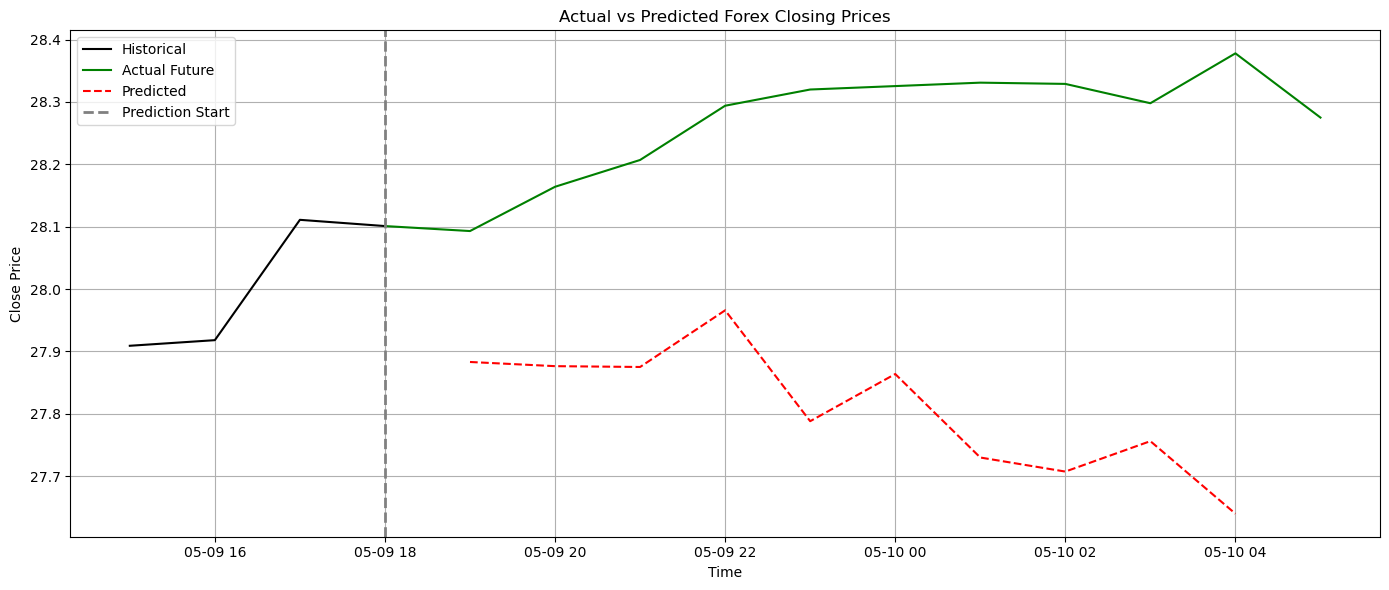

In [14]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [15]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss = model.evaluate(X_test, y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
